## Part 0: Imports, Inializing Global Variables / Arguments, and Dataset and Vocabulary Initalization

In [1]:
# 1 GOOGLE COLAB - DATASET IMPORTS
import os
import random

# 2 BASIC TORCH IMPORTS
import torch
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import models
from torch.utils.data import Dataset, random_split, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
import collections
from sklearn.model_selection import train_test_split

# 3 READING IN IMAGES FROM DATASET
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# 4 TRANSFORMING IMAGES TO DATA
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 5 BUILDING VOCABULARY FROM CAPTIONS
from torchvision.datasets import CocoCaptions
import collections
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
class Args:
    # this class initializes global variables for use in the model and training
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # device to train on -> if GPU is availalble prioritizied

        self.embedding_dim = 256      # embedding dimension for vocabulary
        self.hidden_size = 1024       # hidden size for LSTM unit
        self.max_caption_length = 20  # max caption length generated by model in training

        self.batch_size = 128         # batch size for training
        self.epochs = 5               # number of epochs to train
        self.lr = 0.001               # ADAM optimizer LR
        self.scheduler_rate = 2       # Scheduler decay rate
        self.scheduler_gamma = 0.1    # Scheduler decays LR by this ratio

        self.side_length = 256        # images resized to be this size

        self.train_img_data_path = './train_data' # train dataset path
        self.test_img_data_path = './test_data'   # test dataset path

        self.train_ann_path = './captions_train2014.json' # train annotations path
        self.test_ann_path = './captions_val2014.json'    # test annotations path

args = Args()

In [3]:
# This block fetches the required dataset
# !wget -O train.zip http://images.cocodataset.org/zips/train2014.zip
!wget -O test.zip http://images.cocodataset.org/zips/val2014.zip
!wget -O annotations.zip http://images.cocodataset.org/annotations/annotations_trainval2014.zip

!mkdir -p train_data
!mkdir -p test_data

# !unzip -oj train.zip -d train_data
!unzip -oj test.zip -d test_data
!unzip -oj annotations.zip -d .

Streaming output truncated to the last 5000 lines.
 extracting: test_data/COCO_val2014_000000191304.jpg  
 extracting: test_data/COCO_val2014_000000171062.jpg  
 extracting: test_data/COCO_val2014_000000014549.jpg  
 extracting: test_data/COCO_val2014_000000121152.jpg  
 extracting: test_data/COCO_val2014_000000276596.jpg  
 extracting: test_data/COCO_val2014_000000029431.jpg  
 extracting: test_data/COCO_val2014_000000036349.jpg  
 extracting: test_data/COCO_val2014_000000502055.jpg  
 extracting: test_data/COCO_val2014_000000438848.jpg  
 extracting: test_data/COCO_val2014_000000364973.jpg  
 extracting: test_data/COCO_val2014_000000564166.jpg  
 extracting: test_data/COCO_val2014_000000323327.jpg  
 extracting: test_data/COCO_val2014_000000338581.jpg  
 extracting: test_data/COCO_val2014_000000039656.jpg  
 extracting: test_data/COCO_val2014_000000071667.jpg  
 extracting: test_data/COCO_val2014_000000376046.jpg  
 extracting: test_data/COCO_val2014_000000066394.jpg  
 extracting: t

In [4]:
class IMAGE_DATASET(Dataset):
    # this class initializes the dataset loader interface to use with Pytorch
    def __init__(self, annotations_file, img_dir, ids = None, transform = None, target_transform = None):
        self.img_dir = img_dir                      # directory where dataset is stored
        self.coco = COCO(annotations_file)          # annotation files for image dataset
        self.transform = transform                  # transform functions to apply to image before it is returned
        self.target_transform = target_transform    # transform functions to apply to target label before it is returned
        self.img_keys = list(self.coco.imgs.keys()) if ids is None else ids # image IDs for all images in given dataset

    def get_single_image(self, img_id):
        # load image and annotations
        img = self.coco.loadImgs(img_id)[0]
        annotation_ids = self.coco.getAnnIds(img_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # open and transform image to tensor with needed dimensions
        path = os.path.join(self.img_dir, img['file_name'])
        image = Image.open(path).convert('RGB')

        # apply transformations
        if self.transform:
            image = self.transform(image)

        # choose a random caption out of all possible captions for image
        caption = random.choice(annotations)['caption']

        # return image with random caption choice
        return image, caption

    def __getitem__(self, index):
        # this method allows us to index the dataset like a list
        img_id = self.img_keys[index]
        return self.get_single_image(img_id)

    def __len__(self):
        return len(self.img_keys)

In [5]:
# initialize image transformations
train_transform = transforms.Compose([
    transforms.Resize(args.side_length),              # resize images to same side_length
    transforms.RandomCrop(args.side_length),          # Randomly crop image to side_length
    transforms.RandomHorizontalFlip(),                # Random image flip horizontally
    transforms.ToTensor(),                            # Convert image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   # Normalize image tensor for resnet
])

test_transform = transforms.Compose([
    transforms.Resize(args.side_length),              # Resize images to same side_length
    transforms.CenterCrop(args.side_length),          # Center crop image to side_length
    transforms.ToTensor(),                            # Convert image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   # Normalize image tensor for resnet
])

# train - validation split / test dataset already seperate
id_train, id_val = train_test_split(list(COCO(args.train_ann_path).imgs.keys()), test_size = 0.10)

# Initialize the full dataset
train_dataset = IMAGE_DATASET(args.train_ann_path,
                             args.train_img_data_path,
                             transform = train_transform,
                             ids = id_train)

validate_dataset = IMAGE_DATASET(args.train_ann_path,
                             args.train_img_data_path,
                             transform = test_transform,
                             ids = id_val)

test_dataset = IMAGE_DATASET(args.test_ann_path,
                             args.test_img_data_path,
                             transform = test_transform)

# Initialize the dataloaders to be batched and randomized
image_train_loader = DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                pin_memory=True)

image_validate_loader = DataLoader(dataset=validate_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  pin_memory=True)

image_test_loader = DataLoader(dataset=test_dataset,
                                batch_size=args.batch_size,
                                shuffle=False,
                                pin_memory=True)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [8]:
checkpoint = torch.load('./checkpoint-final.pth')
vocabulary = checkpoint["vocabulary"]
index_to_token = checkpoint["index_to_token"]
vocab_size = len(vocabulary)

<ipython-input-8-33f8a45ba264>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint-final.pth')


In [ ]:
# This block loops over all possible captions to generate a vocabulary
counter = Counter()

# Tokenize captions in both train and test datasets
for ann in list(train_dataset.coco.anns.values()) + list(test_dataset.coco.anns.values()):
    caption = ann['caption'].strip()
    tokens = word_tokenize(caption)
    tokens = ['<sos>'] + tokens + ['<eos>']
    counter.update(tokens)

# Sort by frequency and create vocabulary
sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
vocabulary = {'<pad>': 0, '<unk>': 1}

# Assign indices to other tokens
for idx, (token, _) in enumerate(sorted_by_freq, start=2):
    vocabulary[token] = idx

# Now you have a dictionary where tokens are mapped to indices
vocab_size = len(vocabulary)

# Example: accessing the index for a specific token
token_index = vocabulary.get('<sos>', None)

# In case you want to create a reverse lookup from index to token
index_to_token = {idx: token for token, idx in vocabulary.items()}

In [ ]:
# This block pre-trains a Word2Vec model to generate an embedding layer
corpus = []
for ann in list(train_dataset.coco.anns.values()) + list(test_dataset.coco.anns.values()):
    caption = ann['caption'].strip()
    tokens = word_tokenize(caption)
    corpus.append(tokens)

# Train Word2Vec
embedding_model = Word2Vec(sentences = corpus, vector_size = args.embedding_dim, window = 5, min_count = 1, workers = 4)

# Save the model if needed
embedding_model.save("word2vec.model")

In [9]:
embedding_model = Word2Vec.load("word2vec-3.model")

In [10]:
embedding_matrix = np.zeros((vocab_size, args.embedding_dim))
for word, idx in vocabulary.items():
    if word in embedding_model.wv:
        embedding_matrix[idx] = embedding_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(size=(args.embedding_dim,))

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

In [11]:
class Model(nn.Module):
    def __init__(self, vocab_size):
        super(Model, self).__init__()

        # PART 0: PARAMS
        self.vocab_size = vocab_size

        # PART 1: CNN
        resnet =  models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.CNN = nn.Sequential(*modules)

        self.additional_layers = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(in_features=2048, out_features=args.hidden_size),
          nn.ReLU(),
        )

        self.CNN_LSTM = nn.LSTM(args.hidden_size, args.hidden_size, batch_first = True, bidirectional = True)

        # PART 2: EMBEDDING
        self.embedding = nn.Embedding(vocab_size, args.embedding_dim, padding_idx = 0)
        self.embedding.weight.data.copy_(embedding_tensor)

        # PART 3: LSTM
        self.LSTM = nn.LSTM(args.embedding_dim, args.hidden_size, batch_first = True, bidirectional = True)
        self.FC = nn.Sequential(
            nn.ReLU(),
            nn.Linear(args.hidden_size * 3, args.hidden_size // 2),
            nn.ReLU(),
            nn.Linear(args.hidden_size // 2, vocab_size)
        )

    def forward(self, x, captions):
        batch_size = x.size(0)
        caption_length = captions.size(1)

        with torch.no_grad():
            cnn_features = self.CNN(x).view(batch_size, -1)
            cnn_features = self.additional_layers(cnn_features)
            cnn_repeated = cnn_features.unsqueeze(1).repeat(1, batch_size, 1)
            context, _ = self.CNN_LSTM(cnn_repeated)

        embed = self.embedding(captions)
        outputs, _ = self.LSTM(embed)

        attention_scores = torch.bmm(context, outputs.transpose(1, 2))
        attention_scores = F.softmax(attention_scores, dim=-1)
        attention_context = torch.bmm(attention_scores, outputs)
        context_vector = attention_context.sum(dim=1)

        decoder_input = torch.cat((context_vector, cnn_features), dim=-1)
        output = self.FC(decoder_input)

        return output

In [12]:
# INITIALIZE NETWORK
model = Model(len(vocabulary))
model = model.to(args.device)

print('Using device {}'.format(args.device))

# initialize tokenizer, loss, optimizer, scheduler
loss_func = nn.CrossEntropyLoss(ignore_index = vocabulary['<pad>']).to(args.device)
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.1)
tloss_history = []
vloss_history = []
start_epoch = 0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


Using device cuda


In [21]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])
tloss_history = checkpoint['tloss_history']
vloss_history = checkpoint['vloss_history']
start_epoch = checkpoint['start_epoch']

In [22]:
def pad_sequences(sequences, max_length, pad_token='<pad>'):
    return [seq + [pad_token] * (max_length - len(seq)) if len(seq) < max_length else seq[:max_length] for seq in sequences]

def tokenize_and_pad(labels, vocab, max_length = args.max_caption_length):
    tokenized_labels = [['<sos>'] + word_tokenize(label.strip()) + ['<eos>'] for label in labels]
    padded_labels = pad_sequences(tokenized_labels, max_length)
    indexed_labels = [[vocab[token] for token in seq] for seq in padded_labels]
    return indexed_labels

def process_tokens(predicted_tokens):
    processed_strings = []
    for tokens in predicted_tokens:
        tokens = tokens[1:tokens.index("")]
        processed_string = ' '.join(tokens)
        processed_strings.append(processed_string)

    return processed_strings

In [39]:
def train(num_epochs):
    best_vloss = float('inf')

    for idx_e in range(start_epoch, num_epochs):
        running_loss = 0.0
        last_loss = 0.0
        running_vloss = 0.0

        model.train(True)

        for idx, batch in enumerate(image_train_loader):
            DATA, LABELS = batch

            # Tokenize and pad labels
            tokenized_labels = tokenize_and_pad(LABELS, vocabulary)

            # Convert to tensor
            target_sequences = torch.tensor(tokenized_labels, dtype=torch.long).to(args.device)

            # Get LSTM predictions

            predicted_captions = torch.zeros((target_sequences.size(0), args.max_caption_length, vocab_size), dtype=torch.float).to(args.device)
            sos_one_hot = torch.nn.functional.one_hot(torch.tensor(vocabulary['<sos>']), num_classes=vocab_size).float().to(args.device)
            predicted_captions[:, 0, :] = sos_one_hot

            print(target_sequences)
            return

            for i in range(1, args.max_caption_length):
                pred = model(DATA.to(args.device), target_sequences[:,:i])
                predicted_captions[:, i, :] = pred

            pred_loss = predicted_captions.view(-1, predicted_captions.size(-1))
            target_sequences_loss = target_sequences.view(-1)

            # Calculate loss
            loss = loss_func(pred_loss, target_sequences_loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if idx % 50 == 49:
                last_loss = running_loss / 50
                tloss_history.append(last_loss)
                running_loss = 0
                print(f'Epoch [{idx_e+1}/{num_epochs}], Step [{idx+1}/{len(image_train_loader)}], Loss: {last_loss:.4f}')

                # PRINT SAMPLE SENTENCE:
                probabilities = torch.softmax(predicted_captions[0], dim=-1)
                predicted_indices = torch.argmax(probabilities, dim=-1)
                predicted_tokens = [index_to_token[index] for index in predicted_indices.tolist()]
                print(predicted_tokens, [index_to_token[index] for index in target_sequences[0].tolist()])

        # Validation
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(image_validate_loader):
                DATA, LABELS = batch
                tokenized_labels = tokenize_and_pad(LABELS, vocabulary)
                target_sequences = torch.tensor(tokenized_labels, dtype=torch.long).to(args.device)

                predicted_captions = torch.zeros((target_sequences.size(0), args.max_caption_length, vocab_size), dtype=torch.float).to(args.device)
                sos_one_hot = torch.nn.functional.one_hot(torch.tensor(vocabulary['<sos>']), num_classes=vocab_size).float().to(args.device)
                predicted_captions[:, 0, :] = sos_one_hot

                for i in range(1, args.max_caption_length):
                    pred = model(DATA.to(args.device), torch.argmax(torch.softmax(predicted_captions[:,:i], dim=-1), dim=-1))
                    predicted_captions[:, i, :] = pred

                pred_loss = predicted_captions.view(-1, predicted_captions.size(-1))
                target_sequences_loss = target_sequences.view(-1)
                loss = loss_func(pred_loss, target_sequences_loss)
                running_vloss += loss.item()

        avg_vloss = running_vloss / len(image_validate_loader)
        vloss_history.append(avg_vloss)

        print(f'{idx_e + 1} LOSS train {last_loss} valid {avg_vloss}')

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = './model_{}'.format(idx_e + 1)
            torch.save(model.state_dict(), model_path)

        checkpoint = {
          'start_epoch': idx_e + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'tloss_history': tloss_history,
          'vloss_history': vloss_history,
          'vocabulary': vocabulary,
          'index_to_token': index_to_token
        }
        torch.save(checkpoint, 'checkpoint.pth')
        from google.colab import files
        files.download('checkpoint.pth')
        files.download('./model_{}'.format(idx_e + 1))

        scheduler.step()

# START TRAINING
train(args.epochs)

Epoch [8/20], Step [1/583], Loss: 0.1574
['<sos>', 'A', 'man', 'riding', 'a', 'wave', 'on', 'top', 'of', 'a', 'surfboard', '.', '<eos>', '.', '<eos>', '.', '<eos>', '.', '<eos>', '.'] ['<sos>', 'A', 'man', 'with', 'a', 'red', 'helmet', 'on', 'a', 'small', 'moped', 'on', 'a', 'dirt', 'road', '.', '<eos>', '<pad>', '<pad>', '<pad>']


# Testing

In [ ]:
def test():
    model.eval()
    test_loss = 0
    corpus_score = 0

    with torch.no_grad():
        for i, batch in enumerate(image_test_loader):
            DATA, LABELS = batch
            tokenized_labels = tokenize_and_pad(LABELS, vocabulary)
            target_sequences = torch.tensor(tokenized_labels, dtype=torch.long).to(args.device)

            predicted_captions = torch.zeros((target_sequences.size(0), args.max_caption_length, vocab_size), dtype=torch.float).to(args.device)
            sos_one_hot = torch.nn.functional.one_hot(torch.tensor(vocabulary['<sos>']), num_classes=vocab_size).float().to(args.device)
            predicted_captions[:, 0, :] = sos_one_hot

            for i in range(1, args.max_caption_length):
                pred = model(DATA.to(args.device), torch.argmax(torch.softmax(predicted_captions[:,:i], dim=-1), dim=-1))
                predicted_captions[:, i, :] = pred

            pred_loss = predicted_captions.view(-1, predicted_captions.size(-1))
            target_sequences_loss = target_sequences.view(-1)
            loss = loss_func(pred_loss, target_sequences_loss)

            test_loss += loss.item()
            corpus_score += corpus_bleu([[index_to_token[index] for index in tokenized_labels[i]] for i in range(len(tokenized_labels))],
                                        [[index_to_token[index] for index in predicted_captions.argmax(dim = -1).cpu().numpy()[i]] for i in range(len(DATA))])

        test_loss /= len(image_test_loader)
        corpus_score /= len(image_test_loader)

    return test_loss, corpus_score

test_loss, bleu_score = test()
print(f'Test Loss: {test_loss}, Corpus Score: {bleu_score}')

## Example Images

In [40]:
model.eval()
for i, batch in enumerate(image_test_loader):
      DATA, LABELS = batch
      tokenized_labels = tokenize_and_pad(LABELS, vocabulary)
      target_sequences = torch.tensor(tokenized_labels, dtype=torch.long).to(args.device)

      predicted_captions = torch.zeros((target_sequences.size(0), args.max_caption_length, vocab_size), dtype=torch.float).to(args.device)
      sos_one_hot = torch.nn.functional.one_hot(torch.tensor(vocabulary['<sos>']), num_classes=vocab_size).float().to(args.device)
      predicted_captions[:, 0, :] = sos_one_hot

      for i in range(1, args.max_caption_length):
          pred = model(DATA.to(args.device), torch.argmax(torch.softmax(predicted_captions[:,:i], dim=-1), dim=-1))
          predicted_captions[:, i, :] = pred

      break


In [41]:
predictions = torch.argmax(torch.softmax(predicted_captions[:,:i], dim=-1), dim=-1)

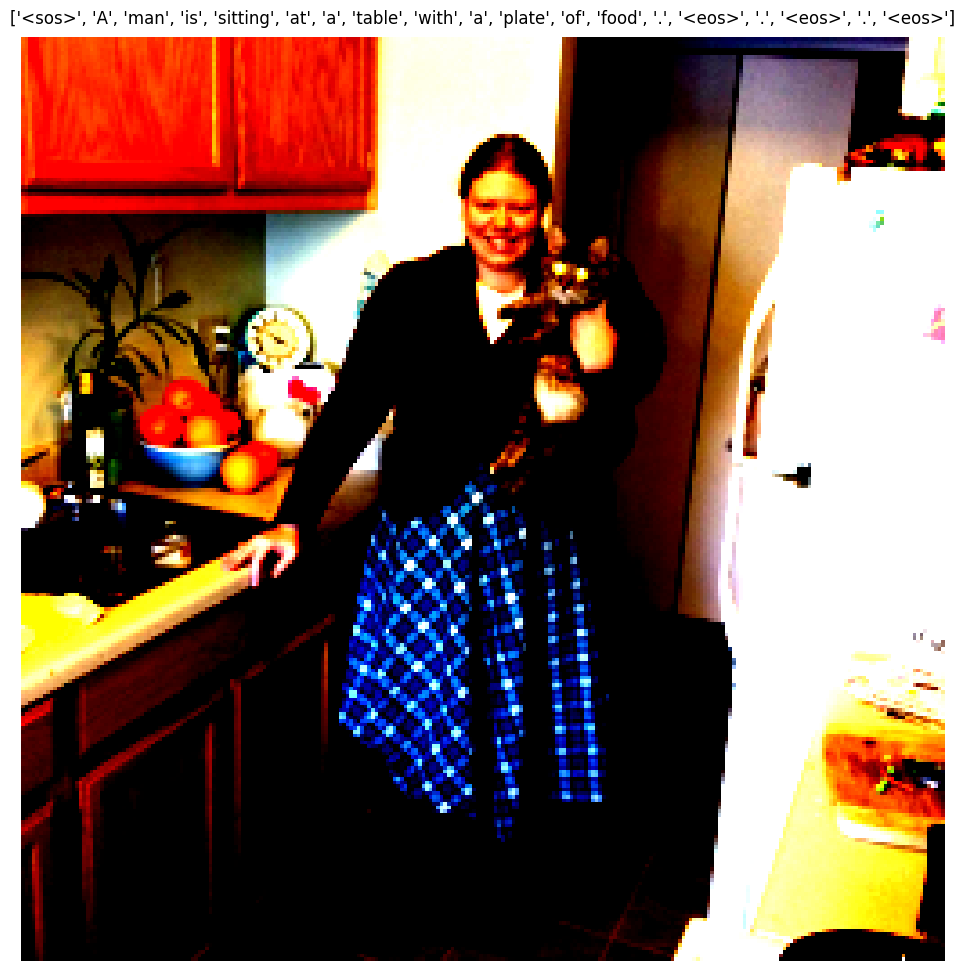

In [57]:
plt.figure(figsize=(12, 12))
plt.imshow(DATA[6].numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title([index_to_token[index] for index in predictions[6].cpu().numpy()], fontsize = 12, pad = 10)
plt.show()